In [ ]:
%load_ext autoreload
%autoreload 2

# get data

In [ ]:
%%sh
# aws s3 cp s3://prabhat-ml/abalone-multivariate/ . --recursive
wget --quiet https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
wget --quiet https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names

# analyze data

In [1]:
import pdb
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )
# device='cpu'

In [3]:
class LinearDataSet(torch.utils.data.Dataset):
    def __init__(self, csv_file):
        super().__init__()
        self.df = pd.read_csv(csv_file, 
                 names=['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Age'])
        
        df_y = self.df.iloc[:,8:]
        df_x = self.df.iloc[:,0:8]
        
        self.y = pd.DataFrame()
        self.y['Age'] = df_y['Age']/df_y['Age'].max()
        
        self.x = pd.get_dummies(df_x, ['Sex'])
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        data = self.x[idx:idx+1].to_numpy()
        label = self.y[idx:idx+1].to_numpy()

        return torch.tensor(data).float(),torch.tensor(label).float()
    
    def head(self, length=5):
        return self.df.head(length)
    
    def headx(self, length=5):
        return self.x.head(length)
    
    def heady(self, length=5):
        return self.y.head(length)


In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 144)
        self.fc2 = nn.Linear(144, 72)
        self.fc3 = nn.Linear(72, 18)
        self.fc4 = nn.Linear(18, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return x        

### set hyperparameters

In [19]:
# device = torch.device("cuda")
epochs = 200

learning_rate = .01
batch_size = 50
print_interval = 100
# print_interval = round(epochs/10)

criterion = nn.MSELoss()
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = LinearDataSet('abalone.data')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4)
# X = X.to(device)
# Y = Y.to(device)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



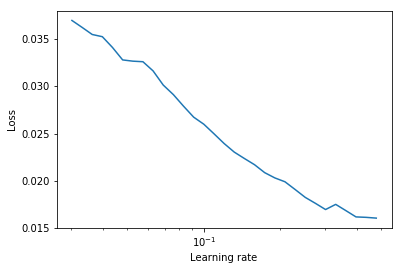

In [20]:
from torch_lr_finder import LRFinder
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

## train

In [21]:
%time

losses = []

model.train()  

for epoch in range(epochs):    
    batch_idx =0
    if epoch % print_interval == 0:
        print('epoch: ', epoch)
        
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        yHat = model(data)
        
        optimizer.zero_grad()

        loss = criterion(yHat,target)

        losses.append(loss.item())
        
#         print('batch_idx: ', batch_idx)

#         if batch_idx % print_interval == 0:
#             print('epoch: ', epoch, ', batch_idx:', batch_idx, 'len(data):', len(data),  ', loss: ', loss.item())

        loss.backward()
    
        optimizer.step()
    
    # validation
#     model.eval()
    
    

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs
epoch:  0
epoch:  100


Text(0, 0.5, 'loss')

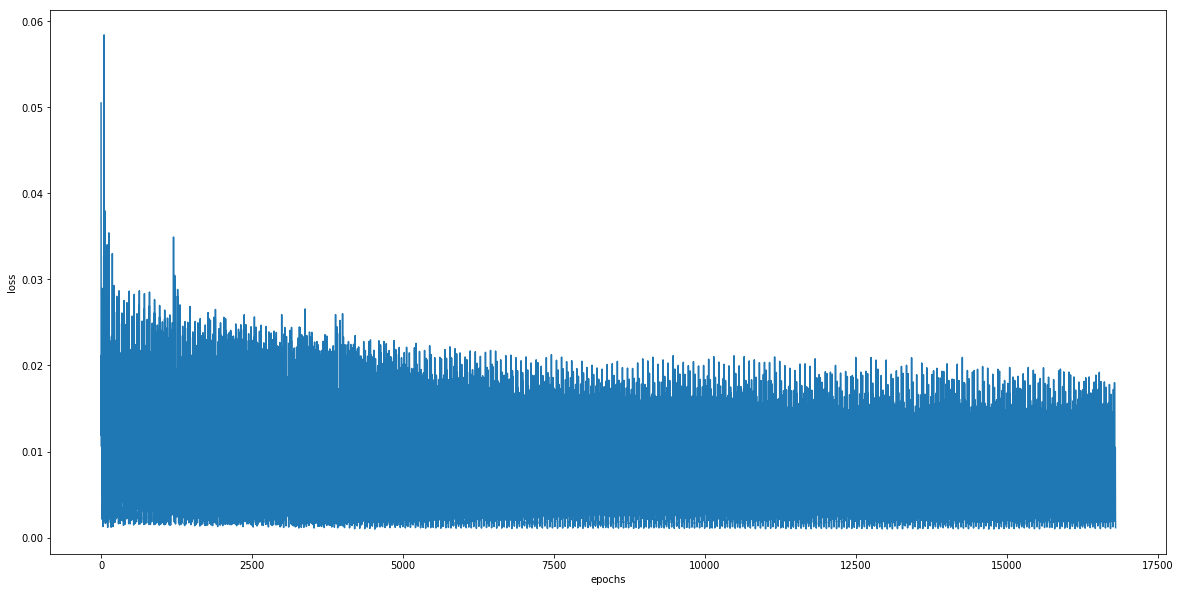

In [23]:
plt.figure(figsize=(20,10))
plt.plot(range(16800), losses)
plt.xlabel('epochs')
plt.ylabel('loss')

In [ ]:
losses[0]

In [24]:
model.eval()
with torch.no_grad():
    yPred = model(X_test.to(device).float())
    plt.figure(figsize=(20,10))
    plt.plot((yPred*29).cpu(), label='prediction')
    plt.plot((Y_test*29).cpu(), label='actual')
    plt.legend()
    

NameError: name 'X_test' is not defined

In [ ]:
%%pixie_debugger